In [21]:
import tensorflow as tf
import numpy as np
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]

# When to use which loss?

You can find an overview of implemented losses in the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/losses)

# Classification

## Binary cross-entropy

When you have a binary classification problem, you will typically have labels `True` and `False`, which equals to labels `1` and `0`. The values output by the last layer are called **logits** and take values in the interval $(-\infty,+\infty)$. For a classification task, we usually want our output to be a *probability*. To do this we need to rescale the logits to the interval $(0,1)$. For binary classification this is achieved by passing the logits through the **sigmoid** function:

\begin{equation}
\hat{y} = \sigma(x) = \frac{1}{1+e^{-x}},
\end{equation}

where is the logit from the output layer. the formula for the binary cross entropy is made up of two parts:

- For the positive class, the base formula for cross entropy is $-y \cdot log(\hat{y})$ where $y$ is the ground truth (i.e. `1`), and $\hat{y}$ is the predicted probability that your label is `1`.

- For the negative class (i.e. `0`), we have $-(1-y)\cdot log(1-\hat{y})$.

By putting these two pieces together we obtain the formula for binary corss entryopy:

\begin{equation}
H(\theta) = \frac{1}{N}\sum_{i=1}^N-(y \cdot log(\hat{y}) + (1-y)\cdot log(1-\hat{y})),
\end{equation}

where $N$ is the total number of examples in your dataset, and $\theta$ are the parameters of your ML model. The dependence of the loss function on the parameters is implicit (i.e. the parameters do not appear explicitly in the formula of the loss function). Can you see which term in equation $(2)$ is implicitly carrying this dependence?

If your true label is `1`, only the first part of the formula above will contribute to the tota loss. Can you see why?

Viceversa, if your true label is `0`, only the second part of the formula above will contribute to the total loss.

Let's see this in practice:

In [15]:
y = 1 # ground truth
y_hat = 0.9 # prediction

# first part of binary cross entropy
print(-y * np.log(y_hat))
# second part of binary cross entropy
print(-(1-y) * np.log(1-y_hat))


0.10536051565782628
-0.0


Let's see what happens to the binary cross entropy for a single case when the probability to belong to the positive class `y_hat` changes.

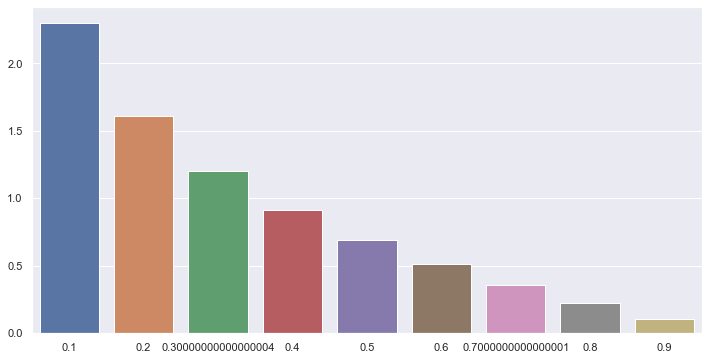

In [24]:
y = 1 # ground truth
y_hat = np.linspace(0.1,0.9,9) # prediction

# individual contribution of one prediction to the total loss
bce = -( y * np.log(y_hat) + (1-y) * np.log(1-y_hat) )

# visualization
sns.barplot(x=y_hat, y=bce);

As expected, the further your prediction is to the true value of `1`, the greater its contribution to the total loss will be. This makes sense since we want a loss function that penalizes mistakes.

How would you expect the above graph to look like for an example whose true value is `y=0`? Try to modify the code in the cell above and see whether the output is in line with your expectations.

In Tensorflow, this loss is implemented by the `BinaryCrossentropy` function. This function takes the option `from_logits` which specifies whether you are applying the function to the logits or the output probabilities. In case `from_logits=True`, the function will first pass the logits through the sigmoid and then compute the loss as in equation $(2)$.

In [25]:
y = [0, 1, 0, 1]
yhat = [0.1, 0.7, 0.3, 0.9] # probabilities
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
bce(y, yhat)

2021-11-23 11:12:28.353375: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(), dtype=float32, numpy=0.23101759>

If we dont use a sigmoid, we can get the output of a linear model, which is called a **logit** and takes values in the range $(-\infty, \infty)$

In [26]:
y = [0, 1, 0, 1]
yhat = [-10.3, 3.2, -17.18, 12.92] # logits
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
bce(y, yhat)

<tf.Tensor: shape=(), dtype=float32, numpy=0.00999736>

## Categorical cross-entropy

If there are two or more label classes in a one-hot encoding, you can use categorical cross entropy.

Let's say we have three possible classes, and the label is the first class, we will have $[1, 0 ,0]$. If we predict the first class with high probability, but the second with small probability we could get something like $[0.95, 0.04, 0.01]$

Note how the sum of the three proabbilities adds up to 1. This is a fundamental property of probabilities and, while in the binary case we enforced it by applying the sigmoid function to the logits, in the multiclass case we use the **softmax** function:

\begin{equation}
\sigma(x)_i = \frac{e^{x_i}}{\sum_{j=1}^Ke^{x_j}},
\end{equation}

where $K$ is the number of classes. Once we have the probability for each class, we can compute the categorical cross-entropy loss as:

\begin{equation}
H(\theta) = \frac{1}{N}\sum_{i=0}^N\sum_{j=1}^K y_{i,j} \cdot log(\hat{y}_{i,j})
\end{equation}

where $N$ is the number of examples in the dataset, $K$ is the number of classes.

If you have logits on the range $(-\infty, \infty)$ as output (i.e., you dont use an activation function) you can set `from_logits=True`.

In [27]:
y = [[0, 1, 0], [0, 0, 1]] # one-hot encoded labels
yhat = [[0.04, 0.95, 0.01], [0.1, 0.8, 0.1]]
# Using 'auto'/'sum_over_batch_size' reduction type.
loss = tf.keras.losses.CategoricalCrossentropy()
loss(y, yhat).numpy()

1.1769392

## Sparse categorical cross-entropy

In case your classes are not one-hot encoded, you can use `SparseCategoricalCrossentropy` to compute the categorical cross-entropy.

In [29]:
y = [1, 2] # labels not one-hot encoded
yhat = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
# Using 'auto'/'sum_over_batch_size' reduction type.
scce = tf.keras.losses.SparseCategoricalCrossentropy()
scce(y, yhat).numpy()


1.1769392

## Multi-class, Multi-label
The most general case occurs when there are multiple classes to predict, and each instance can take multiple labels from the set of categories at the same time. E.g. you can have a three classes for movies ['commedy', 'sci-fi', 'horror'] and you are watching a movie that is both a comedy, and sci-fi. Your label will be $[1, 0, 1]$ and your prediction might be something like $[0.7, 0.5, 0.6]$. Or in the case of an x-ray of a chest: you might have pneumonia and/or cancer, or none of them.

**Note**: for this case, the sum of the probabilities for each class does not necessarily have to add up to one because each class is not mutually exclusive. In this case, you should use the binary crossentropy. If you use a softmax, your values will sum to one. But that is not what you want! Because it is multilabel, you want to allow for multiple values to get close to one, so use a sigmoid as activation function. You can also use this with logits.

In [30]:
y_true = [[1, 0, 1], [0, 0, 1]]
y_pred = [[5.0, -10.0, 5], [-5.0, -10, 20]]
loss = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)
loss.numpy()

array([0.00449203, 0.00225358], dtype=float32)

In [31]:
y = [[0, 1, 0], [0, 0, 1]]
yhat = [[0.04, 0.95, 0.01], [0.1, 0.8, 0.1]]
loss = tf.keras.losses.binary_crossentropy(y, yhat, from_logits=False)
loss.numpy()

array([0.0340551, 1.3391274], dtype=float32)

# Regression

TODO: Write a brief intro about the characteristics of the loss function for regression problems.

## Mean Absolute Error (MAE)

The MAE is computed as 

\begin{equation}
\mathcal{L}(\hat{y}, y)=\frac{1}{N}\sum_{i=1}^N |y-\hat{y}|.
\end{equation}

The MAE measure the error in the same scale of the data, i.e. if you are predicting the price in dollars the unit of the MAE will be dollars as well. The distance of each prediction `y_hat` from the ground truth `y` contributes linearly to the total MAE. This implies that outliers are not heavily penalized. In case you want to penalize outliers heavily, you may want to consider other loss functions.

- Why do we need to take the absolute value of `y-y_hat` to have a valid measure of the error?

In [34]:
y = np.array([10.2, 5.1, 8.12])
yhat = np.array([2.2, 6.0, 9.2])
loss = tf.keras.losses.MAE(y, yhat)

assert np.array_equal(
    loss.numpy(), np.mean(np.abs(y - yhat), axis=-1))

loss.numpy()


3.326666666666666

In the above example, there is a clear outlier, which one? Let's introduce a new loss function that can be used it to penalize it better than what the MAE does.


Try to change the outlier in the code, and note how the two loss functions react differently to the outlier.

## Mean Squared Error (MSE)

\begin{equation}
MSE = \frac{1}{N}\sum_{i=1}^N(y_i-\hat{y}_i)^2
\end{equation}

Contrary to MAE, the units of the MSE are the square of the unit of the labels. For example, if you are predicting the area of a house in $m^2$, then your MSE will be in $m^4$. What is an obvious way to have the same units as those of the lables/

In [36]:
loss = tf.keras.losses.MSE(y, yhat)

assert np.array_equal(
    loss.numpy(), np.mean(np.square(y - yhat), axis=-1))

loss.numpy()

21.992133333333328

In the example above MSE > MAE because of the presence of an outlier. Do you understand why squaring the difference $y-y_hat$ penalizes outliers more than taking the absolute value as in the MAE?

## Mean Squared Logarithmic Error

If the target value has a huge spread, you might want to be easier on errors for the very large values. With this, you can use the mean squared logarithmic error:

$$\mathcal{L}(\hat{y}, y)=\frac{1}{m}\sum_{i=1}^m ((log(y+1) -log(\hat{y} + 1))^2$$

In [39]:
loss = tf.keras.losses.mean_squared_logarithmic_error(y, yhat)
loss.numpy()

0.5336267729497567

## Remarks

These are just some of the many loss functions that can be used for classification and regression tasks. Often, the choice of the right loss function can improve the performance of the ML model because the way errors are compute affects the value of the gradients (remember backprop?) and these, in turn, affect how the model parameters are updated.

## Food for thought

- Can we use a regression loss, i.e. MAE for a classification problem?
- What is the difference between a *loss* and a *metric*?
- Can we use a metric as a loss? Can we use a loss as a metric?